(3, 23, 23)


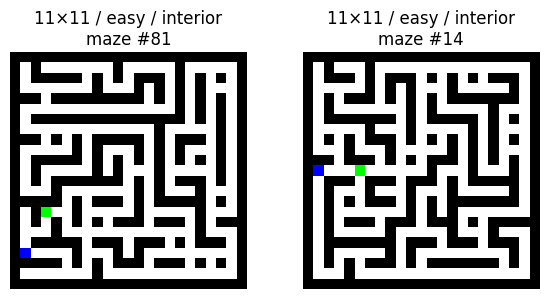

(3, 23, 23)


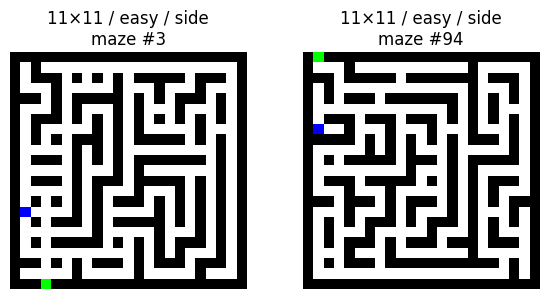

(3, 23, 23)


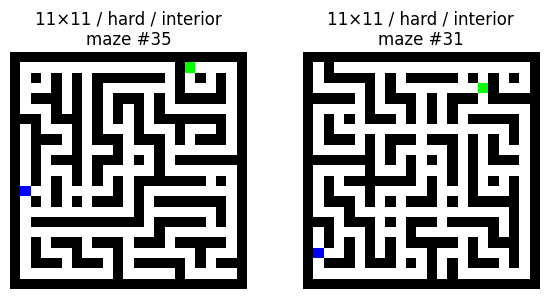

(3, 23, 23)


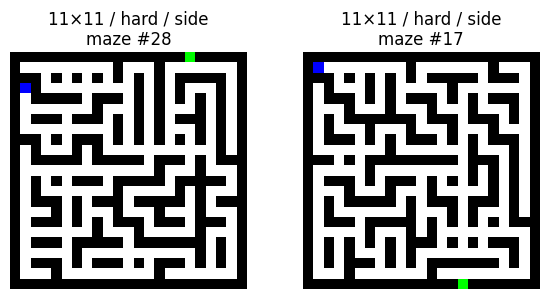

(3, 23, 23)


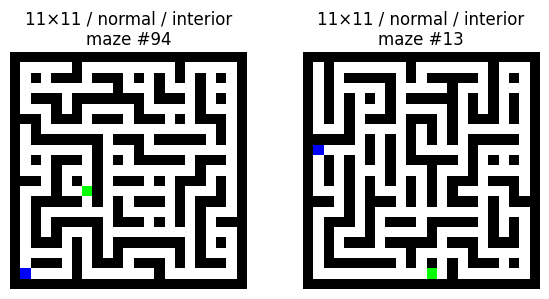

(3, 23, 23)


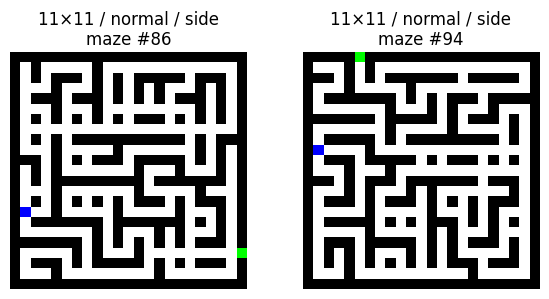

(3, 31, 31)


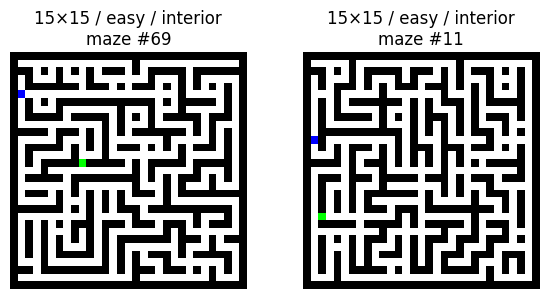

(3, 31, 31)


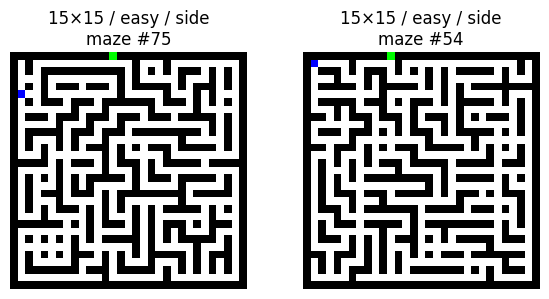

(3, 31, 31)


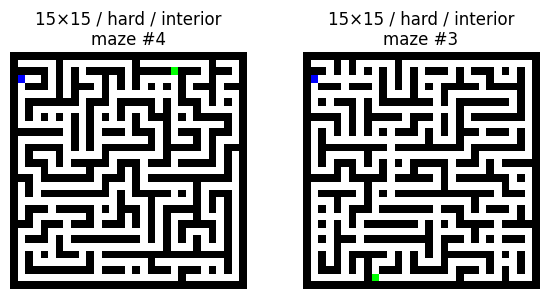

(3, 31, 31)


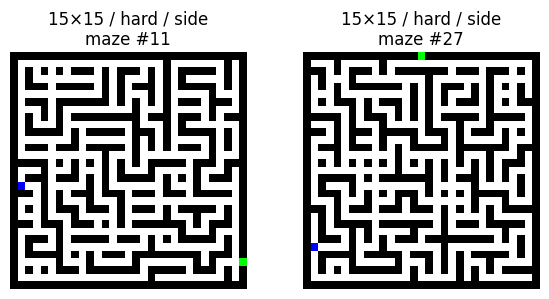

(3, 31, 31)


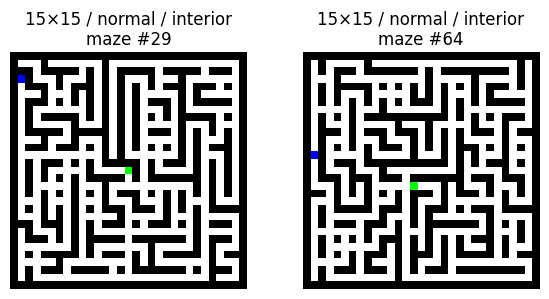

(3, 31, 31)


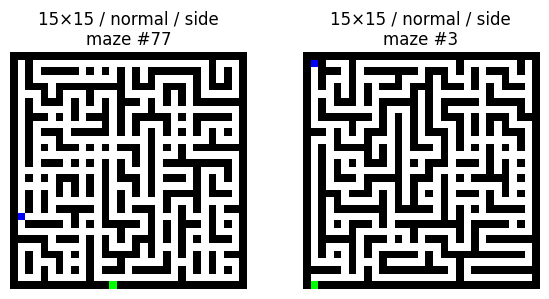

(3, 15, 15)


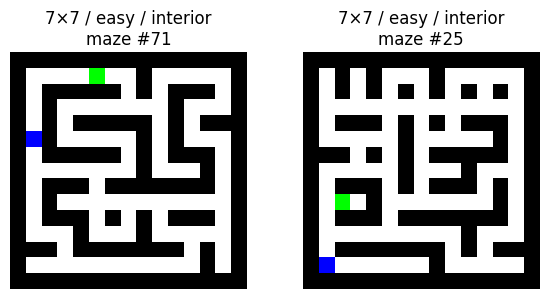

(3, 15, 15)


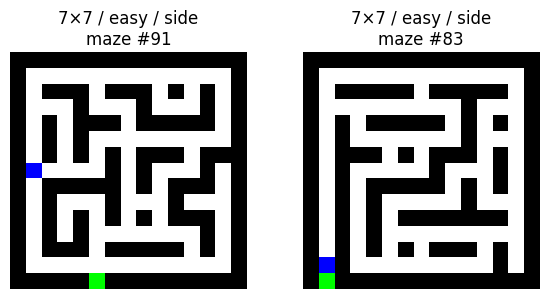

(3, 15, 15)


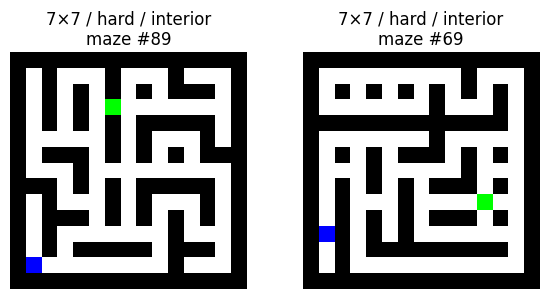

(3, 15, 15)


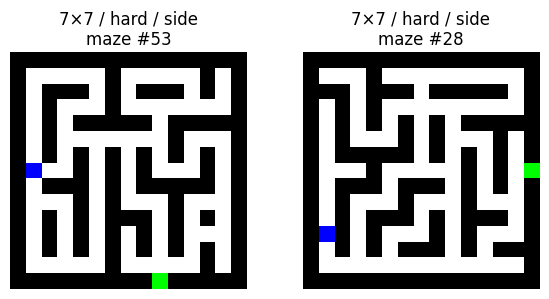

(3, 15, 15)


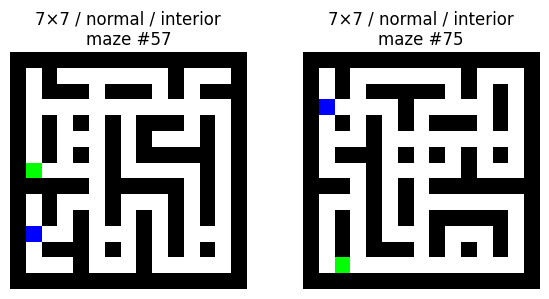

(3, 15, 15)


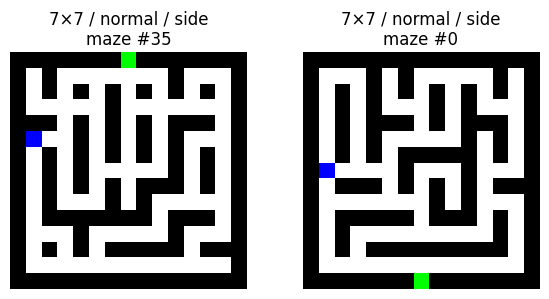

In [1]:
import glob
import os
import pickle
import random
import re

import matplotlib.pyplot as plt
import numpy as np
from MazeEnv import MazeEnv

EVAL_DIR = "eval_mazes"
N_PER_BUCKET = 2
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# regex pattern
PATTERN = re.compile(r"(?P<size>\d+)_(?P<diff>easy|normal|hard)_(?P<exit>side|interior)\.pkl$")

def bucket_label(size, diff, exit_t):
    return f"{size}×{size} / {diff} / {exit_t}"

files = sorted(glob.glob(os.path.join(EVAL_DIR, "*_*.pkl")))
if not files:
    raise RuntimeError(f"No bucket files found in {EVAL_DIR!r}")

for file in files:
    m = PATTERN.search(os.path.basename(file))
    if not m:
        continue

    size = int(m.group("size"))
    diff = m.group("diff")
    exit_t = m.group("exit")
    label = bucket_label(size, diff, exit_t)

    with open(file, "rb") as f:
        mazes = pickle.load(f)

    n_show = min(N_PER_BUCKET, len(mazes))
    idxs = random.sample(range(len(mazes)), n_show)

    env = MazeEnv(
        n_mazes=1,
        maze_size=size,
        max_ep_len=1,
        n_previous_states=1,
        use_visited=False,
        partial_obs=False,
    )

    fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
    if n_show == 1:
        axes = [axes]

    for ax, idx in zip(axes, idxs):
        env.reset(maze=mazes[idx].copy())
        ax.imshow(env.render())
        ax.set_title(f"{label}\nmaze #{idx}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


15_hard_interior.pkl
(3, 31, 31)

Successful episode


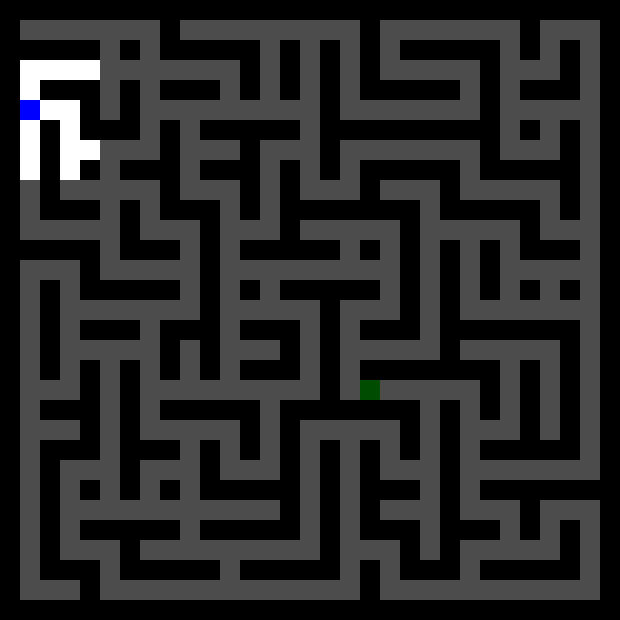


Failed episode


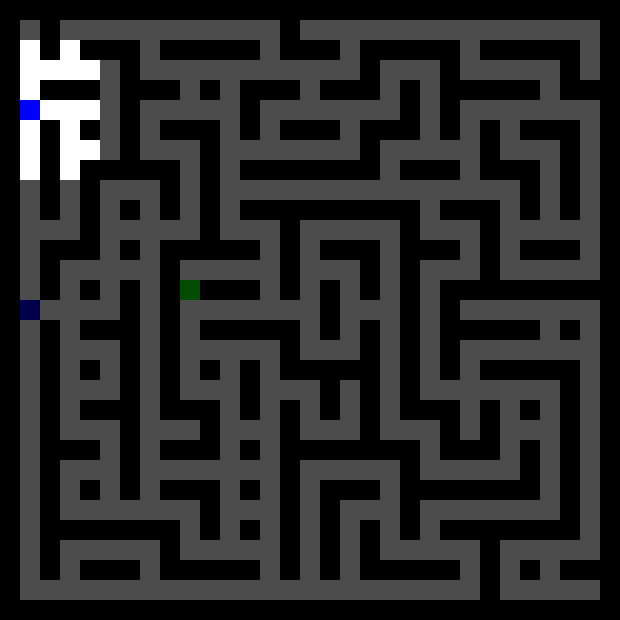

In [55]:
import pickle, numpy as np
from pathlib import Path

from MazeEnv import MazeEnv
from sb3_contrib import RecurrentPPO
from stable_baselines3 import PPO

import random

eval_dir = Path("eval_mazes")
model_path = Path("saved_models_2/PPO_7x7_1p5M_cnn_128_n4_partial_recurrent_MDL1e-06.zip")
max_steps = 200

maze_size = 15
diff = ["hard"]
exit_t = ["interior"]

mazes = []

for fname in [f"{maze_size}_{d}_{t}.pkl" for d in diff for t in exit_t]:
    print(fname)
    with (eval_dir / fname).open("rb") as f:
        mazes.extend(pickle.load(f))

name = model_path.stem.lower()
partial = "partial" in name
recurrent = "recurrent" in name
n_prev = 4 if "n4" in name else 1

env = MazeEnv(
    n_mazes=len(mazes),
    maze_size=maze_size,
    max_ep_len=max_steps,
    n_previous_states=n_prev,
    use_visited=True,
    partial_obs=partial,
)
env.mazes = mazes

ModelCls = RecurrentPPO if recurrent else PPO
model = ModelCls.load(model_path)

def run_once(e: MazeEnv, pol, wipe = False) -> bool:

    obs, _ = e.reset(maze=e.current_maze.copy())
    lstm_state = None
    first_step_flag = True 
    
    while True:
        if recurrent:
            action, lstm_state = pol.predict(
                obs, state=lstm_state, episode_start=np.array([first_step_flag]), deterministic=True
            )
        else:
            action, _ = pol.predict(obs, deterministic=True)
        
        first_step_flag = wipe

        obs, _, done, truncated, _ = e.step(int(action))

        if done or truncated :
            # print(f"Done ? {e.dist_from_goal() == 0}")
            return e.dist_from_goal() == 0

success_maze, failure_maze = None, None

while success_maze is None or failure_maze is None : 
    m = random.choice(mazes)
# for m in mazes :
    env.current_maze = m.copy()
    outcome = run_once(env, model)

    # env.current_maze = m.copy()
    # outcome_wiped = run_once(env,model,wipe=True)
    outcome_wiped = False

    if outcome and not outcome_wiped and success_maze is None:
        success_maze = m
    elif not outcome and failure_maze is None:
        failure_maze = m

    # if success_maze is not None and failure_maze is not None :
    #     break

assert success_maze is not None, "Agent never solved any 15_hard maze!"
assert failure_maze is not None, "Agent actually solved every 15_hard maze!"

print("\nSuccessful episode")
env.current_maze = success_maze.copy()
env.show_episode(policy=model, recurrent=recurrent, random_maze=False)

# print("Same maze but without LSTM state")
# env.show_episode(policy=model, recurrent=recurrent, random_maze=False, wipe = True)

print("\nFailed episode")
env.current_maze = failure_maze.copy()
env.show_episode(policy=model, recurrent=recurrent, random_maze=False)
